## CNN-RNN Forward Proxy Modeling for CO2 Monitoring

#### Team MOMA: 
#### Misael M. Morales & Oriyomi Raheem
##### Hildebrand Department of Petroleum & Geosystems Engineering
##### The University of Texas at Austin

***
#### GEO 391 - Machine Learning Applications in Geoscience
##### Department of Geological Sciences, Jackson School of Geosciences
***


### Executive Summary
Forward reservoir simulation refers to the construction and numerical operation of a subsurface model that approximates the behavior of a true reservoir based on governing physical equations through numerical discretization. Given a set of equations, parameters, and assumptions, the numerical  simulator approximates the dynamic behavior of the actual reservoir. However, this process is dependent on high-resolution finite difference schemes that require high computational costs, due to the large amount of data involved.

Deep learning has proved a ubiquitous tool for the approximation of large-scale systems. Through the Universal Approximation Theorem, one can build a neural network that sufficiently approximates the dynamics and results of any function. Convolutional Neural Networks (CNN) have proved to be extremely efficient for image processing and dimensionality reduction. Recurrent Neural Networks (RNN) have proved to be useful for learning dynamic states for sequences and time-series data. The development and application of these technologies can allow for more computationally efficient techniques for forward reservoir simulation.

Here, we develop a hybrid CNN-RNN as a proxy model for a forward reservoir simulator in a CO2 monitoring scenario. The data comes from high-fidelity simulations using MRST, and is preprocessed and augmented for improved training. The proxy model is built using a block structure as follows: (1) Convolutional block for dimensionality reduction into a latent space, (2) Recurrent block for the prediction of dynamic states in latent space, and (3) Deconvolutional block for the prediction of time-dependent high-resolution maps from the latent representation.

This model will learn to forecast dynamic states (saturation) from he latent representation of static pretrophysical properties (permeability) using a reduced-order forward model. This allows for significantly more efficient reservoir simulations and can be expanded to possible applications in uncertainty quantification, history matching, and more.

### Table of Contents
1. Problem Setup
2. Import Packages
3. Declare Functions
4. Load & Preprocess Data
5. CNN-RNN Forward Proxy
6. Results & Discussion
7. References

***

### 1. Problem Setup

We use the MRST (Matlab Reservoir Simulation Toolbox) to generate high-fidelity simulations for the injection and subsequent migration of CO2 in the SPE 10 model, a benchmark model for reservoir simulation. The top layers of the model represent the Tarbet formation, a prograding near shore environment with Gaussian-distributed rock properties, while the bottom layers represent the Upper Ness formation, a fluvial depositional environment.

The original model is 60 x 220 x 85 cells, with sizes of 20 ft x 10 ft x 2 ft. However, we split generate an ensemble of 2D realizations from the full model by taking each individual layer and splitting it into four 60 x 60 maps in each of the 85 layers. This gives a total of 255 realizations to simulate. 

We run forward simulations using an Automatic Differentiation framework for a period of 5 years injection, monitored monthly (60 timesteps total). The numerical model uses Peaceman's well model, where there is only one injector well in the center of the grid (30,30), and the control is given for a constant injection rate of 5 meters^3/day. The reservoir is originally fully saturated with brine and the injection is pure CO2. With this, we monitor the reservoir pressure and CO2 saturation over time. The results from the high-fidelity simulations are collected along with the rock properties realizations. 

Using this as training data, we fit a CNN-RNN model to learn how to forecast dynamic states from the latent representation of the static reservoir properties (a reduced-order forward model). We perform data augmentation by rotating 90 degrees the feature and target images, for a total of 510 data. This is then split randomly into training and testing sets, and a percentage of traning data is used for validation.The deep learning model is then designed using a block structure that reduces the permeability realizations into a latent space using convolutions, then predicts dynamic latent states using recurrent layers, and then predicts a cube of time-lapse saturation maps in high-resolution. 

This proxy model will allow for more efficient reservoir simulations and possible applications in uncertainty quantification, history matching, and more.

***

### 2. Import Packages

We start by importing our most basic packages:

In [135]:
%matplotlib inline
import numpy as np                                     #arrays and matrix math
import matplotlib.pyplot as plt                        #plotting and visualization

Import other important packages for preprocessing, metrics, etc., and project-specific packages and functions

In [136]:
# Data loading
from scipy import io as sio                           #import matlab files

# Training timer
from time import time                                 #timer for training

# Goodness-of-Fit Metrics
from skimage.metrics import mean_squared_error        #Mean Squared Error (MSE)
from skimage.metrics import structural_similarity     #Structural Similarity Index (SSIM)

# Project-specific
import keras
from keras import Model, regularizers
from keras.layers import Input
from keras.layers import BatchNormalization, LeakyReLU
from keras.layers import Flatten, Reshape, RepeatVector
from keras.layers import Conv2D, MaxPooling2D, Conv3D, Conv3DTranspose, GRU

We check the TensorFlow setting to ensure that a GPU is available for training

In [137]:
# Check tensorflow GPU settings
import tensorflow as tf
sys_info = tf.sysconfig.get_build_info()
print('Tensorflow built with CUDA?',  tf.test.is_built_with_cuda())
print('# GPU available:', len(tf.config.experimental.list_physical_devices('GPU')))
print("CUDA: {} | cuDNN: {}".format(sys_info["cuda_version"], sys_info["cudnn_version"]))
tf.config.list_physical_devices()

Tensorflow built with CUDA? True
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

***

### 3. Delcare Functions
The following functions will be used in the workflow.

In [138]:
# Function to plot a few samples from the (augmented) dataset
def plot_dataset(poro, perm, saturation, nrows=6, row_mult=75, dim=60, figsize=(20,10)):
    ncols, col_mult = 5, 12
    fig, axs = plt.subplots(nrows, ncols+3, figsize=figsize, tight_layout=True)
    for i in range(nrows):
        for j in range(ncols):
            # Plot saturation maps
            axs[i,j].imshow(saturation[i*row_mult,:,:,j*col_mult], cmap='plasma')
            axs[i,j].set(yticklabels=[], xticklabels=[], xticks=[], yticks=[])
            axs[i,0].set_ylabel('Realization {}'.format(i*row_mult))
            axs[0,j].set_title('State {}'.format(j*col_mult))
            # Plot (final state) saturation map
            axs[i,-3].imshow(saturation[i*row_mult,:,:,-1], cmap='plasma')
            axs[0,-3].set_title('State 60') 
            # Plot porosity map
            pom = axs[i,-2].imshow(poro[i*row_mult,:,:], cmap='viridis')
            axs[0,-2].set(title='Porosity')
            # Plot permeability map
            pem = axs[i,-1].imshow(perm[i*row_mult,:,:], cmap='jet')
            axs[0,-1].set(title='Log Permeability') 
        # Plot injector location
        for j in range(ncols+3):
            axs[i,j].plot(dim/2,dim/2, 'kh')
        for j in np.arange(ncols,ncols+3):
            axs[i,j].set(xticks=[], xticklabels=[], yticklabels=[])
        fig.colorbar(pom, ax=axs[i,-2], shrink=0.9)
        fig.colorbar(pem, ax=axs[i,-1], shrink=0.9)


In [139]:
# Function to plot training process
def plot_loss(fit):
    epochs     = len(fit.history['loss'])
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['loss'],     '-', label='loss')
    plt.plot(iterations, fit.history['val_loss'], '-', label='validation loss')
    plt.title('Training: MSE vs epochs'); plt.legend()
    plt.xlabel('Epochs'); plt.ylabel('MSE')
    plt.xticks(iterations[::epochs//10])

In [140]:
# Function to plot to mean distributions of target and feature maps for train/test sets
def plot_histograms(X_training_flat, X_testing_flat, y_training_flat, y_testing_flat):
    plt.figure(figsize=(10,4))
    # Mean Permeability
    plt.subplot(121)
    plt.hist(X_training_flat.mean(axis=1), density=True, bins=15, label='train')
    plt.hist(X_testing_flat.mean(axis=1), density=True, bins=15, alpha=0.4, label='test')
    plt.title('Mean LogPerm Distribution - Train/Test')
    plt.xlabel('Mean Log Permeability'); plt.legend()
    # Mean End Saturation
    plt.subplot(122)
    plt.hist(y_training_flat.mean(axis=1), density=True, bins=15, label='train')
    plt.hist(y_testing_flat.mean(axis=1), density=True, bins=15, alpha=0.4, label='test')
    plt.title('Mean End Saturation Distribution - Train/Test')
    plt.xlabel('Mean End Saturation Permeability'); plt.legend()

In [141]:
# Function to visualize the true and predicted saturation maps for permeability realization
def compare_results_plot(X_test, y_true, y_pred, nrows=4, row_mult=40, figsize=(20,7)):
    month_states = [0, 11, 23, 35, 47, 59]
    fig, axs = plt.subplots(4, 13, figsize=figsize, tight_layout=True)
    for i in range(nrows):
        for j in np.arange(len(month_states)):
            # Show true saturation states (y_test)
            axs[i,j].imshow(y_true[i*row_mult, :, :, month_states[j]], cmap='plasma')
            axs[i,j].set(yticklabels=[], xticklabels=[], xticks=[], yticks=[])
            # Show predicted saturation sates (y_pred)
            k = j+7
            axs[i,k].imshow(y_pred[i*row_mult, :, :, month_states[j]], cmap='plasma')
            axs[i,k].set(yticklabels=[], xticklabels=[], xticks=[], yticks=[])
            # Add axis labels
            axs[i,0].set_ylabel('Realization {}'.format(i*row_mult))
            axs[0,j].set_title('State {}'.format(month_states[j]+1))
            axs[0,k].set_title('State {}'.format(month_states[j]+1))
        # Show permeability map (X)
        axs[i,len(month_states)].imshow(X_test[i*row_mult,:,:], cmap='jet')
        axs[i,len(month_states)].set(yticklabels=[], xticklabels=[], yticks=[])
        axs[0,len(month_states)].set_title('Log Perm')

***

### 4. Load & Preprocess Data

Preprocessing is usually one of the most time-consuming yet most important steps in machine learning. Improper or biased data will only result in a meaningless or biased prediction. Therefore, we perform the following data processing steps: loading, reshaping, augmentation by rotation, Min-Max normalization, and random train/test split. 

In [142]:
# Load data from high-fidelity simulations
poro_df       = sio.loadmat('simulations/poro')['poro']              #porosity [frac]
perm_df       = sio.loadmat('simulations/perm')['perm']              #permeability[mD]
saturation_df = sio.loadmat('simulations/saturation')['saturation']  #saturation[frac]
pressure_df   = sio.loadmat('simulations/pressure')['pressure']      #pressure[Pascal]

print('Porosity shape: {} | Permeability shape: {}'.format(poro_df.shape, perm_df.shape))
print('Pressure shape: {} | Saturation shape: {}'.format(pressure_df.shape, saturation_df.shape))

Porosity shape: (255, 3600) | Permeability shape: (255, 3600)
Pressure shape: (255, 3600, 60) | Saturation shape: (255, 3600, 60)


We define a few key variables from the high-fidelity simulation results

In [143]:
dim      = 60    #size of images (60x60)
N_real   = 255   #number of realizations
N_states = 60    #number of states

In [144]:
poro       = np.reshape(poro_df, [N_real,dim,dim])                  #porosity maps
perm       = np.log10(np.reshape(perm_df, [N_real,dim,dim]))        #log10(perm) maps
saturation = np.reshape(saturation_df, [N_real,dim,dim,N_states])   #saturation maps & states
pressure   = np.reshape(pressure_df, [N_real,dim,dim,N_states])     #pressure maps & states

print('Porosity shape: {}     | Permeability shape: {}'.format(poro.shape, perm.shape))
print('Pressure shape: {} | Saturations  shape: {}'.format(pressure.shape, saturation.shape))

Porosity shape: (255, 60, 60)     | Permeability shape: (255, 60, 60)
Pressure shape: (255, 60, 60, 60) | Saturations  shape: (255, 60, 60, 60)


We perform data augmentation by rotating the images 90 degrees, and then concatenating with the original images to provide a doubled dataset. We also shuffle the new doubled dataset to have the different orientations mixed throughout the dataset and not at the end. This allows the proxy model to learn the true dynamics of the reservoir disregarding orientation.

In [145]:
# Data Augmentation
# rotate to make new images
poro_flip        = np.rot90(poro, axes=(2,1))
perm_flip        = np.rot90(perm, axes=(2,1))
saturation_flip  = np.rot90(saturation, axes=(2,1))

# concatenate original and rotated images & shuffle
poro_cat         = np.concatenate((poro, poro_flip), axis=0)
perm_cat         = np.concatenate((perm, perm_flip), axis=0)
saturation_cat   = np.concatenate((saturation, saturation_flip), axis=0)

# Shuffle full dataset with (set) random index
idx = np.random.choice(a=N_real*2, size=N_real*2, replace=False)
poro_aug, perm_aug = np.zeros(poro_cat.shape), np.zeros(perm_cat.shape)
saturation_aug = np.zeros(saturation_cat.shape)
for i in range(len(idx)):
    poro_aug[i,:,:] = poro_cat[idx[i],:,:]
    perm_aug[i,:,:] = perm_cat[idx[i],:,:]
    saturation_aug[i,:,:,:] = saturation_cat[idx[i],:,:,:]

print('Augmented Porosity shape:     {}'.format(poro_aug.shape)) 
print('Augmented Permeability shape: {}'.format(perm_aug.shape)) 
print('Augmented Saturation shape:   {}'.format(saturation_aug.shape))

Augmented Porosity shape:     (510, 60, 60)
Augmented Permeability shape: (510, 60, 60)
Augmented Saturation shape:   (510, 60, 60, 60)


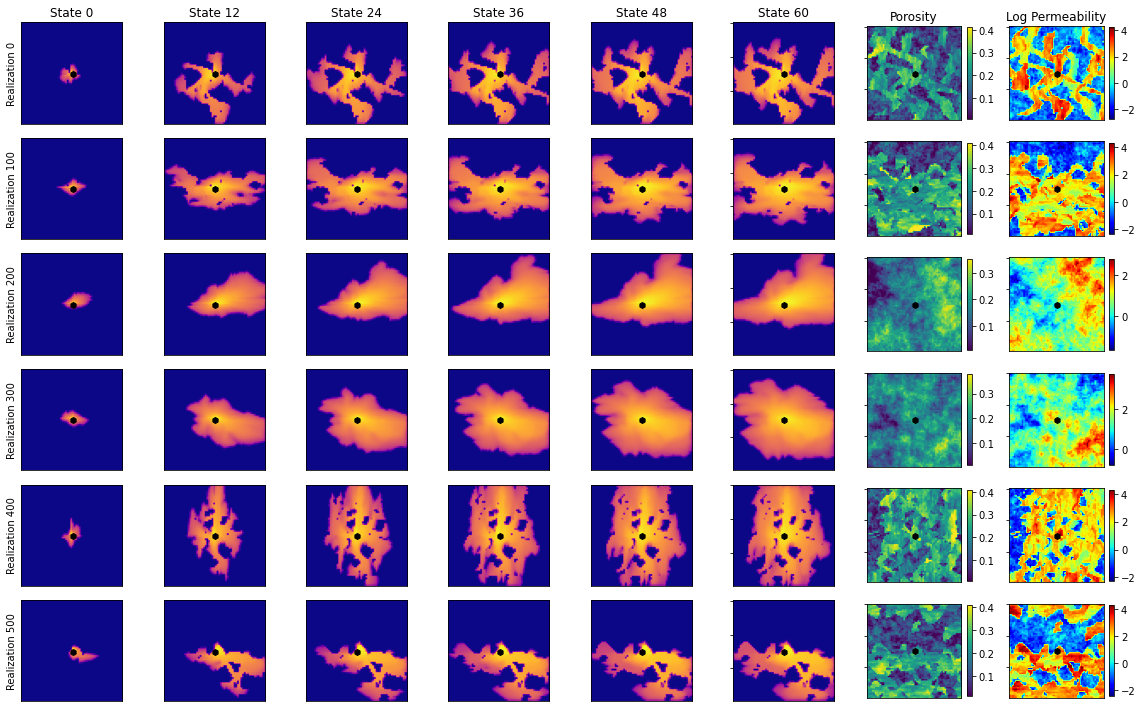

In [146]:
# Visualize (True Data) Saturation over time & porosity/permeability
plot_dataset(poro_aug, perm_aug, saturation_aug, nrows=6, row_mult=100, figsize=(16,10))

We normalize the data to be $\in[0,1]$; this is known as Min-Max Normalization. This improves the prediction performance of the proxy model given the properties of the activation functions and optimizers in the deep learning framework.

In [147]:
# Min-Max Normalize predicted saturation values ~ [0,1]
perm_min = perm_aug.min(axis=(1,2), keepdims=True)
perm_max = perm_aug.max(axis=(1,2), keepdims=True)
perm_processed = (perm_aug - perm_min)/(perm_max-perm_min)

sat_min = saturation_aug.min(axis=(1,2), keepdims=True)
sat_max = saturation_aug.max(axis=(1,2), keepdims=True)
sat_processed = (saturation_aug - sat_min)/(sat_max-sat_min)

print('Processed Permeability shape: {}'.format(perm_processed.shape))
print('Processed Saturation shape:   {}'.format(sat_processed.shape))

Processed Permeability shape: (510, 60, 60)
Processed Saturation shape:   (510, 60, 60, 60)


We perform train/test split by randomly generating a set of indices that will be assigned to the training set and the remainder to the testing set. 

In [148]:
# Randomly generate train-test indices
split_perc = (2/3)
train_size = int(np.ceil(N_real*2 * split_perc))
test_size  = int(np.floor(N_real*2 * (1-split_perc)))

train_idx = np.random.choice(N_real*2, size=train_size, replace=False)
test_idx  = np.setdiff1d(np.arange(N_real*2), train_idx)

# Train/Test split
X_train = np.expand_dims(perm_processed[train_idx,:,:], axis=-1)
X_test  = np.expand_dims(perm_processed[test_idx,:,:],  axis=-1)
y_train = np.expand_dims(sat_processed[train_idx,:,:,:], axis=-1)
y_test  = np.expand_dims(sat_processed[test_idx,:,:,:],  axis=-1)

print('X_train shape: {} | y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_test  shape: {} | y_test  shape: {}'.format(X_test.shape,  y_test.shape))

X_train shape: (340, 60, 60, 1) | y_train shape: (340, 60, 60, 60, 1)
X_test  shape: (170, 60, 60, 1) | y_test  shape: (170, 60, 60, 60, 1)


We visualize the distribution of mean permeability and mean end-state saturation for the training and testing datasets. This is a measure to ensure that the training set is representative of the testing, and that no induced bias will be introduced in training so that the model can generalize well to the testing set.

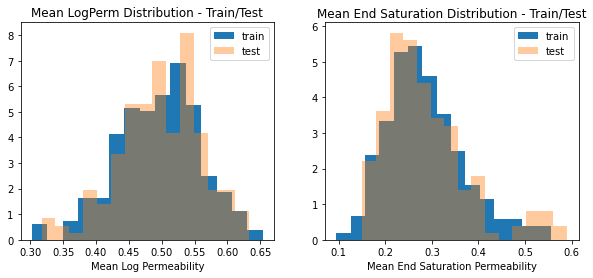

In [149]:
# Visualize Train/Test distributions (mean, flattened)
X_train_f = X_train.reshape(train_size, dim*dim)
X_test_f  = X_test.reshape(test_size, dim*dim)

y_train_f = y_train[:,:,:,-1].reshape(train_size, dim*dim)
y_test_f  = y_test[:,:,:,-1].reshape(test_size, dim*dim)

plot_histograms(X_train_f, X_test_f, y_train_f, y_test_f)

***

### 5. CNN-RNN Forward Proxy

The model is a hybrid CNN-RNN architecture that will learn how to forecast dynamic states from the latent representation of the static reservoir properties (a reduced-order forward model). The architecture is designed as follows:

1. Convolution block: dimensionality reduction from high-resolution permeability to a latent space
2. Recurrent block: dynamic predictions in latent space
3. Deconvolution block: reconstruct high-resolution saturation maps as a time-series


In [150]:
# (re)-Set Keras environment
keras.backend.clear_session()
tf.keras.backend.set_floatx('float32')

In [151]:
# Define proxy model by blocks
global_reg = 1e-4

# Convolutional block (Encoder)
def conv_block(filt, inp, kern=(3,3), reg=global_reg):
    x = Conv2D(filters=filt, kernel_size=kern, padding='same', activation=LeakyReLU(alpha=0.3))(inp)
    x = Conv2D(filters=filt, kernel_size=kern, padding='same', kernel_regularizer=regularizers.l2(reg))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    return x

# Recurrent block
def rnn_block(units, inp, drop=0.2):
    x = Flatten()(inp)
    x = RepeatVector(n=125)(x)
    x = GRU(units=units, return_sequences=True, dropout=drop)(x)
    x = Reshape((5,5,5, x.shape[-1]))(x)
    return x

# Transpose Convolutional block (Decoder)
def convT_block(filt, stride, inp, kern=(3,3,3), reg=global_reg):
    x = Conv3DTranspose(filters=filt, kernel_size=kern, padding='same', strides=1,      activation=LeakyReLU(alpha=0.3))(inp)
    x = Conv3DTranspose(filters=filt, kernel_size=kern, padding='same', strides=stride, activation=LeakyReLU(alpha=0.3))(x)
    x = Conv3DTranspose(filters=filt, kernel_size=kern, padding='same', kernel_regularizer=regularizers.l2(reg))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    return x

# Output block
def output_block(filt, inp, kern=(3,3,3)):
    x = Conv3DTranspose(filters=filt[0], kernel_size=kern, padding='same', activation='sigmoid')(inp)
    x = Conv3D(filters=filt[1], kernel_size=kern, padding='same', activation='sigmoid')(x)
    return x


In [152]:
# Define CNN-RNN forward proxy model
def make_proxy():
    keras.backend.clear_session()

    # Input layer
    inp = Input(shape=(dim,dim,1))

    # Encoder block
    x = conv_block(filt=8,  inp=inp)
    x = conv_block(filt=16, inp=x)
    x = conv_block(filt=32, inp=x)
    x = conv_block(filt=64, inp=x)

    # Recurrent block
    x = rnn_block(units=128, inp=x)

    # Decoder block
    x = convT_block(filt=64, stride=2, inp=x)
    x = convT_block(filt=32, stride=2, inp=x)
    x = convT_block(filt=16, stride=3, inp=x)

    # Output block
    out = output_block(filt=[8,1], inp=x)

    proxy_model = Model(inp, out)
    return proxy_model

In [153]:
model = make_proxy()
print('Number of parameters: {:,}'.format(model.count_params()))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

Number of parameters: 930,121


Training time: 12.17 minutes


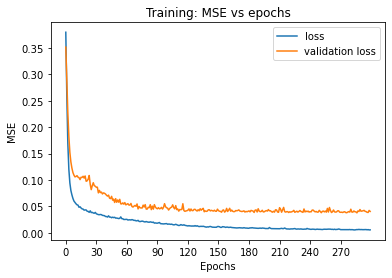

In [154]:
# Compile model
opt = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(optimizer = opt,
                loss    = 'mse',
                metrics = ['mse'])

# Fit the model
start = time()
fit = model.fit(X_train, y_train,
                    shuffle          = True,
                    epochs           = 300,
                    validation_split = 0.25,
                    batch_size       = 40,
                    workers          = 10,
                    verbose          = 0)
train_time = time()-start
print('Training time: {:.2f} minutes'.format(train_time/60))

# Visualize training process
plot_loss(fit)

In [155]:
########################################
##### Save/Load (pre)trained model #####
########################################

model.save('model.h5')
#model = keras.models.load_model('model.h5')

Next we visualize the training performance. This includes computing MSE and SSIM metrics for the true training data and model-predicted training data. We also plot in a single image the permeability map (features) and the true and predicted saturation states (targets).

In [156]:
# Predict TRAIN dynamic saturation states
y_train_hat = model.predict(X_train).squeeze().astype('float64')

# MinMax Normalize predicted saturation values ~ [0,1]
y_min  = y_train_hat.min(axis=(1,2), keepdims=True)
y_max  = y_train_hat.max(axis=(1,2), keepdims=True)
y_train_pred = ((y_train_hat - y_min)/(y_max-y_min))

# Squeeze the training dataset
y_train = y_train.squeeze()

# Print shapes
print('y_train_pred shape: {}'.format(y_train_pred.shape))
print('y_train shape:      {}'.format(y_train.shape))

11/11 [==============================] - 1s 74ms/step
y_train_pred shape: (340, 60, 60, 60)
y_train shape:      (340, 60, 60, 60)


In [157]:
# Compute error metrics for training data
mse_train  = mean_squared_error(y_train, y_train_pred)
ssim_train = structural_similarity(y_train, y_train_pred)
print('MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_train, ssim_train))

MSE: 0.016 | MSSIM: 0.817


We also visualize the testing performance. We compute the MSE and SSIM metrics for the true testing data and model-predicted testing data. Lastly, we plot in a single image the permeability maps (features) and the true and predicted saturation states (targets).

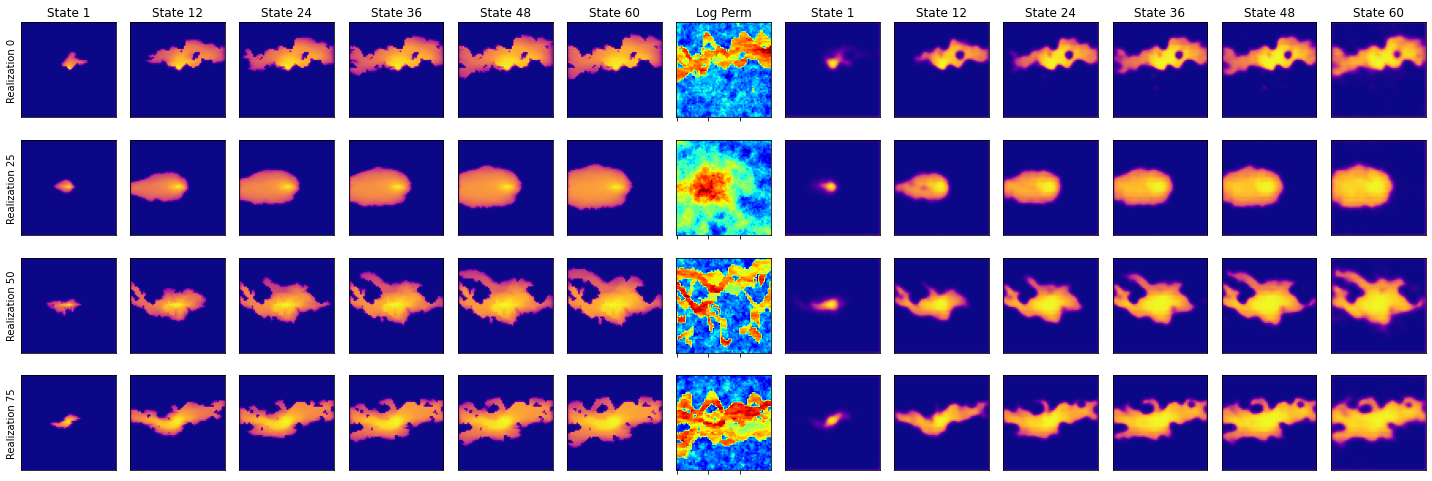

In [158]:
# Compare true vs. training saturations for a set of permeability realizations
compare_results_plot(X_train, y_train, y_train_pred, nrows=4, row_mult=25)

In [159]:
# Predict TEST dynamic saturation states
y_test_hat = model.predict(X_test).squeeze().astype('float64')

# MinMax Normalize predicted saturation values ~ [0,1]
y_min  = y_test_hat.min(axis=(1,2), keepdims=True)
y_max  = y_test_hat.max(axis=(1,2), keepdims=True)
y_test_pred = ((y_test_hat - y_min)/(y_max-y_min))

# Squeeze the testing data
y_test = y_test.squeeze()

# Print shapes
print('y_test_pred shape: {}'.format(y_test_pred.shape))
print('y_test shape:      {}'.format(y_test.shape))

6/6 [==============================] - 1s 113ms/step
y_test_pred shape: (170, 60, 60, 60)
y_test shape:      (170, 60, 60, 60)


In [160]:
# Compute error metrics for testing data
mse  = mean_squared_error(y_test, y_test_pred)
ssim = structural_similarity(y_test, y_test_pred)
print('MSE: {:.3f} | MSSIM: {:.3f}'.format(mse, ssim))

MSE: 0.040 | MSSIM: 0.563


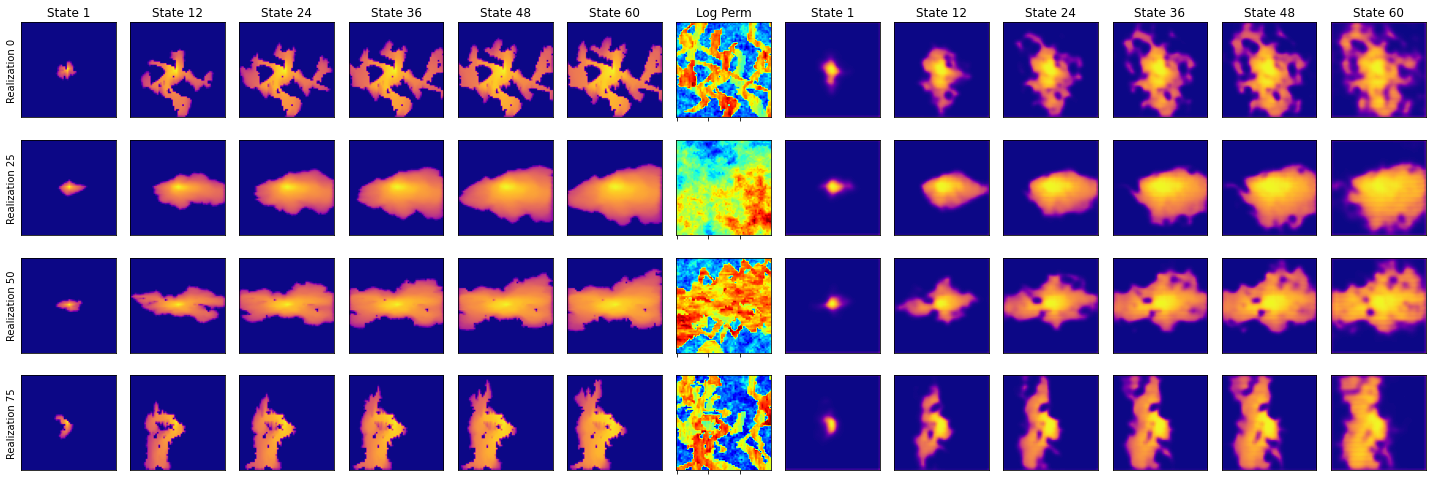

In [161]:
# Compare true vs. testing predicted saturations for a set of permeability realizations
compare_results_plot(X_test, y_test, y_test_pred, nrows=4, row_mult=25)

***

### 6. Results and Discussion

High-fidelity simulation:
- Numerical reservoir simulation is often appreciated as ground truth, but it is a time-consuming and computationally complex process. We use MRST to develop the reservoir model and generate the dynamic forecasts for a CO2 injection project. This is a toy example, with a small number of cells and small injection rate - each map is only (60,60) and the forecast is 60 timesteps long. However, the time-per-simulation is approximately 20 seconds.

Data Processing:
- The static and dynamic forecasts from MRST are collected and arranged for ease-of-use in Python and Keras. We perform data augmentation so that orientation is not learned but rather the physical behavior of the system, and shuffle so that there is no preference in training for fluvial versus Gaussian maps. We normalize the data to aid the training, and then randomly split into training and testing sets.

Proxy Model:
- The model is built in a block fashion, with an Encoder structure, and Recurrent block in latent-space, and a Decoder structure. The total number of parameters is approximately 930,000, and the training is done over 300 epochs using Adam optimizer with a batch size of 40 and a validation split of 25%. The training takes approximately 17 minutes on a Nvidia RTX 3080 GPU. After training, each prediction for the test set is done in approximately 0.5 milliseconds, a 40,000x speedup!

Results:
- The proxy model is extremely efficient in predicting dynamic saturation states from a static permeability map. The model is able to generate 60 timesteps for the 60x60 maps in very little time and high accuracy. The mean squared error (MSE) is approximately 0.033 and the mean structural similarity index (SSIM) is approximately 0.55. The MSE is extremely good since this is what we used as a metric in our optimizer, however the SSIM is not quite as acceptable, but still good. By visual inspection, the predictions are still representative of the high-fidelity simulations.


**Conclusions:**

Deep Learning proves as a power tool for numerical reservoir simulation. With significant speedups compared to high-fidelity industrial and commercial software, neural networks are at the forefront of modern petroleum technology. Designing competent architectures and training with processed data seems to justify the switch to deep learning proxies. However, high-fidelity reservoir simulation is still required to generate the training data and will always be a time-consuming but required step.

Further studies could include incorporating a new loss function with MSE and SSIM, so that the predicted images are more coherent with the ground truth visually and numerically. Further applications could include using the proxy model to perform uncertainty quantification, history matching, closed-loop optimization, and other research topics in reservoir engineering. Also, this architecture could be trained and applied for problems in groundwater flows, contaminant transport, and petroleum production projects.

### 7. References:

* Maldonado-Cruz, Eduardo, and Michael J Pyrcz. (2022) “Fast Evaluation of Pressure and Saturation Predictions with a Deep Learning Surrogate Flow Model.” Journal of petroleum science & engineering 212 
* Kim, Y. D., & Durlofsky, L. J. (2022). "Convolutional-Recurrent Neural Network Proxy for Robust Optimization and Closed-Loop Reservoir Management." arXiv preprint arXiv:2203.07524.
* Kaur, Harpreet et al. (2022) “Time-Lapse Seismic Data Inversion for Estimating Reservoir Parameters Using Deep Learning.” Interpretation (Tulsa) 10.1
* S. Pan, S.L. Brunton, and J.N. Kutz (2022) "Neural Implicit Flow: a mesh-agnostic dimensionality reduction paradigm of spatio-temporal data." arXiv preprint arXiv:2204.03216
* Joon, Shams, Dawuda, Ismael, Morgan, Eugene, and Sanjay Srinivasan. (2022) "Rock Physics-Based Data Assimilation of Integrated Continuous Active-Source Seismic and Pressure Monitoring Data during Geological Carbon Storage." SPE Journal.
* Gonzalez, Keyla, and Siddharth Misra. (2022) “Unsupervised Learning Monitors the Carbon-Dioxide Plume in the Subsurface Carbon Storage Reservoir.” Expert systems with applications 201
* K.G. Gurjao, E. Gildin, R. Gibson, and M. Everett. (2022) "Estimation of Far-Field Fiber Optics Distributed Acoustic Sensing DAS Response Using Spatio-Temporal Machine Learning Schemes and Improvement of Hydraulic Fracture Geometric Characterization." SPE Hydraulic Fracturing Technology Conference and Exhibition, USA
* Salazar, Jose J et al. (2022) “Fair Train-Test Split in Machine Learning: Mitigating Spatial Autocorrelation for Improved Prediction Accuracy.” Journal of petroleum science & engineering 209:109885–.
* Tang, Meng, Yimin Liu, and Louis J Durlofsky. (2021) “Deep-Learning-Based Surrogate Flow Modeling and Geological Parameterization for Data Assimilation in 3D Subsurface Flow.” Computer methods in applied mechanics and engineering 376:113636–.
* H. Jo, Y. Cho, M.J. Pyrcz, H. Tang, and P. Fu (2021) "Machine learning-based porosity estimation from spectral decomposed siesmic data." arXiv preprint arXiv:2111.13581
* Wen, Gege, Catherine Hay, and Sally M Benson. (2021) “CCSNet: A Deep Learning Modeling Suite for CO2 Storage.” Advances in water resources 155:104009–.
* Alsulaimani, Thamer , and Mary Wheeler. (2021) "Reduced-Order Modeling for Multiphase Flow Using a Physics-Based Deep Learning." SPE Reservoir Simulation Conference
* E.J.R. Coutinho, M.J. Aqua and E. Gildin. (2021) "Physics-Aware Deep-Learning-Based Proxy Reservoir Simulation Model Equipped with State and Well Output Prediction." SPE Reservoir Simulation Conference, Virtual.
* Ciriello, V., Lee, J. & Tartakovsky, D.M. (2021) "Advances in uncertainty quantification for water resources applications." Stoch Environ Res Risk Assess 35, 955–957 
* Pan, W., Torres-Verdín, C. & Pyrcz, M.J. (2021) "Stochastic Pix2pix: A New Machine Learning Method for Geophysical and Well Conditioning of Rule-Based Channel Reservoir Models." Nat Resour Res 30, 1319–1345
* Wu, Hao et al. (2021) “A Multi-Dimensional Parametric Study of Variability in Multi-Phase Flow Dynamics During Geologic CO2 Sequestration Accelerated with Machine Learning.” Applied energy 287:116580–.
* Santos, J.E., Yin, Y., Jo, H. et al. (2021) "Computationally Efficient Multiscale Neural Networks Applied to Fluid Flow in Complex 3D Porous Media." Transp Porous Med 140, 241–272
* Chan, S., Elsheikh, A.H. (2020) "Data-driven acceleration of multiscale methods for uncertainty quantification: application in transient multiphase flow in porous media." Int J Geomath 11,3 
* Cheung, S.W., Chung, E.T., Efendiev, Y. et al. (2020) "Deep global model reduction learning in porous media flow simulation." Comput Geosci 24, 261–274
* Almasov, Azad , Onur, Mustafa , and Albert C. Reynolds. (2020) "Production Optimization of the CO2 Huff-N-Puff Process in an Unconventional Reservoir Using a Machine Learning Based Proxy." SPE Improved Oil Recovery Conference, Virtual
* Jiang, Chiyu lmaxr et al. (2020) “MESHFREEFLOWNET: A Physics-Constrained Deep Continuous Space-Time Super-Resolution Framework.” SC20: International Conference for High Performance Computing, Networking, Storage and Analysis. IEEE 1–15.
* J. Nagoor Kani, Elsheikh, A.H. (2019) "Reduced-Order Modeling of Subsurface Multi-phase Flow Models Using Deep Residual Recurrent Neural Networks." Transp Porous Med 126, 713–741
* Jayne, Richard S, Hao Wu, and Ryan M Pollyea. (2019) “Geologic CO2 Sequestration and Permeability Uncertainty in a Highly Heterogeneous Reservoir.” International journal of greenhouse gas control 83.C:128–139.
* K.-A. Lie. (2019) "An Introduction to Reservoir Simulation Using MATLAB/GNU Octave: User Guide for the MATLAB Reservoir Simulation Toolbox (MRST)." Cambridge University Press
* Brunton, Steven L., and Jose Nathan Kutz. (2019) "Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control." 1st ed. Cambridge University Press
* Guo, Zhenyu, and Albert C Reynolds. (2018) “Robust Life-Cycle Production Optimization With a Support-Vector-Regression Proxy.” SPE journal 23.6:2409–2427
* Naraghi, Morteza Elahi, Spikes, Kyle , and Sanjay Srinivasan. (2017) "3D Reconstruction of Porous Media From a 2D Section and Comparisons of Transport and Elastic Properties." SPE Res Eval & Eng 20:342–352
* Ampomah, W et al. (2017) “Optimum Design of CO2 Storage and Oil Recovery Under Geological Uncertainty.” Applied energy 195 
* J. Nagoor Kani, Elsheikh, A.H. (2017) "DR-RNN: A deep residual recurrent neural network for model reduction." arXiv preprint arXiv:1709.00939

***

### About Us

$\textbf{Misael}$ is currently a PhD student in Petroleum & Geosystems Engineering at The University of Texas at Austin, supervised by Drs. Pyrcz and Torres-Verdin. His background is in Petroleum Engineering & Applied Mathematics from the University of Tulsa.

At UT, Misael is working on the computational description of subsurface energy and environmental systems. He combine domain-specific knowledge with tools from machine learning & deep learning, math and statistics, for accurate characterization and forecasting of complex dynamical systems in the subsurface. His work is centered on integrated applied energy data analytics by developing novel technologies, practical workflows, demos and documentation to support the digital revolution in energy, and his focus is on machine learning and data science applications for subsurface modeling and simulation, including: uncertainty quantification, inverse modeling, data assimilation, control & optimization, and physics-informed predictive analytics.
##### misaelmorales@utexas.edu | [GitHub](https://github.com/misaelmmorales) | [Website](https://sites.google.com/view/misaelmmorales) | [LinkedIn](https://www.linkedin.com/in/misaelmmorales)


$\textbf{Oriyomi}$ is currently a PhD student in Petroleum & Geosystems Engineering at The University of Texas at Austin, supervised by Dr. Torres-Verdin.

I have over 5 years of experience working as a Production and Reservoir Engineering with TEPNG, Exxonmobil and Oil Servicing companies. I presently work as a Research Assistant at the University of Texas at Austin on "Applications of data science and machine learning to formation evaluation", while concurrently doing my PhD in Petroleum Geosystems Engineering. I have verse coding experience with C/C++, Python programming which I have used large to achieve objectives during my professional experiences.

##### oriyomiraheem@utexas.edu

***

# END